# Overview
This notebook explores the cleaned ramen-ratings CSV. Any engineered features or scripts will be added to explore.py.

# Findings
1. Ramen packaging and five-star ratings are independent.
2. Ramen country of origin and five-star ratings **have a dependent relationship.**

In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle

In [2]:
# create train split for exploration
train, _, _ = wrangle.prep_explore()
print('')

# check work
train.info()

Train size: (1515, 5) Validate size: (506, 5) Test size: (506, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1515 entries, 2566 to 2127
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   brand       1515 non-null   object
 1   name        1515 non-null   object
 2   package     1515 non-null   object
 3   country     1515 non-null   object
 4   five_stars  1515 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 60.7+ KB


# Initial Exploration of Ramen Packaging
Let's check if there's a dependent relationship between packaging and our target.

Hypotheses:
- $H_0$: Packaging and five-star ratings are independent.
- $H_a$: Packaging and five-star ratings have a dependent relationship.

Confidence interval: 95%

In [3]:
# set confidence interval
alpha = .05

In [4]:
# check dependence of packaging and target
package_5star_crosstab = pd.crosstab(train.package, train.five_stars)
_, p, _, _ = stats.chi2_contingency(package_5star_crosstab)

In [5]:
# check if p is significant
if p < alpha:
    print("Packaging and five-star ratings have a dependent relationship with 95% confidence.")
    print("p-value:", p)
else:
    print("Packaging and five-star ratings are independent, did not pass 95% confidence interval.")
    print("p-value:", p)

Packaging and five-star ratings are independent, did not pass 95% confidence interval.
p-value: 0.43924606238117814


**Packaging and five-star ratings are independent.** We will not use 'package' in our predictive model.

# Initial Exploration of Ramen Country of Origin
Let's check if there's a dependent relationship between country and our target.

Hypotheses:
- $H_0$: Country of origin and five-star ratings are independent.
- $H_a$: Country of origin and five-star ratings have a dependent relationship.

Confidence interval: 95%

In [6]:
# set confidence interval
alpha = .05

In [7]:
# create crosstab for chi-square statistical test
country_5star_crosstab = pd.crosstab(train.country, train.five_stars)
# limit only to countries with sufficient value counts in crosstab (an assumption of chi-square)
enough_values_mask = (country_5star_crosstab[False] > 5) & (country_5star_crosstab[True] > 5)
# run chi-square test
_, p, _, _ = stats.chi2_contingency(country_5star_crosstab[enough_values_mask])

In [8]:
# check if p is significant
if p < alpha:
    print("Country of origin and five-star ratings have a dependent relationship with 95% confidence.")
    print("p-value:", p)
else:
    print("Country of origin and five-star ratings are independent, did not pass 95% confidence interval.")
    print("p-value:", p)

Country of origin and five-star ratings have a dependent relationship with 95% confidence.
p-value: 1.680501270556502e-06


**Country of origin and five-star ratings have a dependent relationship.** We will further explore country of origin and consider using it in our model.

# Initial Exploration of Ramen Brand
Let's check if there's a dependent relationship between ramen brand and our target.

Hypotheses:
- $H_0$: Ramen brand and five-star ratings are independent.
- $H_a$: Ramen brand and five-star ratings have a dependent relationship.

Confidence interval: 95%

In [9]:
# set confidence interval
alpha = .05

In [10]:
# create crosstab for chi-square statistical test
brand_5star_crosstab = pd.crosstab(train.brand, train.five_stars)
# limit only to brands with sufficient value counts in crosstab (an assumption of chi-square)
enough_values_mask = (brand_5star_crosstab[False] > 5) & (brand_5star_crosstab[True] > 5)
# run chi-square test
_, p, _, _ = stats.chi2_contingency(brand_5star_crosstab[enough_values_mask])

In [11]:
# check if p is significant
if p < alpha:
    print("Ramen brand and five-star ratings have a dependent relationship with 95% confidence.")
    print("p-value:", p)
else:
    print("Ramen brand and five-star ratings are independent, did not pass 95% confidence interval.")
    print("p-value:", p)

Ramen brand and five-star ratings are independent, did not pass 95% confidence interval.
p-value: 0.22292206264805428


**Ramen brand and five-star ratings are independent.** We will not use 'brand' in our predictive model.

# Breaking Down the Ramen Product Name
Nearly all ramen reviews in our dataset have a unique combination of brand and product name. Only 21 combinations of brand and product out of the nearly 1500 in our exploration split have two reviews, and there are no combinations with more than two reviews. Because of this low commonality, we can't run initial chi-square tests to see if product names have a dependent relationship with five star reviews.

In [12]:
# show the review repeats and non-repeats
print("Brand+name with only one review:", (train[['brand','name']].value_counts() == 1).sum())
print("Brand+name with two reviews:", (train[['brand','name']].value_counts() == 2).sum())
print("Brand+name with more than two reviews:", (train[['brand','name']].value_counts() > 2).sum())

Brand+name with only one review: 1473
Brand+name with two reviews: 21
Brand+name with more than two reviews: 0


Before we can understand the relationship between product name and the target, we will need to split out certain keywords in product names to use as features.

## Identifying Keywords to Use
**Ramen names will require multiple features** due to the fact that a ramen product can have many attributes.

Another issue is that some product names use English and some do not use English. In order to accomodate this, **we will need to translate some words** to English and include them in our features (EX: put "soy" and "shoyu"/"shouyu" into one feature).

### Word Checks

In [13]:
# print a list of countries with a ramen product
print(train.country.unique().tolist())

['South Korea', 'USA', 'Hong Kong', 'UK', 'Thailand', 'Japan', 'Taiwan', 'Malaysia', 'India', 'Canada', 'Singapore', 'Philippines', 'China', 'Mexico', 'Indonesia', 'Cambodia', 'Netherlands', 'Australia', 'Nepal', 'Vietnam', 'Myanmar', 'Germany', 'Pakistan', 'Hungary', 'Colombia', 'Bangladesh', 'Brazil']


In [14]:
# checking product names by country (cell ran multiple times with different inputs)
# train[train.country == 'Taiwan'].name.tolist()

In [15]:
# checking count of values matching the string (cell ran multiple times with different inputs)
# (train.name.str.contains('Cake') == True).sum()

In [16]:
# checking row's values for rows containing matched string (cell ran multiple times with different inputs)
# train[train.name.str.contains('Teriyaki')]

### Identifying Remaining Keywords
The following keyword mask contains all the words I've designated as keywords. This keyword conglomeration will be unpacked in a readable format in the sections below this section.

In [17]:
# identify all keywords, prepare list for df.col.str.contains()
keyword_mask = '|'.join(['Vermicelli', 'Vernicalli', 'Bihun', 'Sano', 'Chicken', 'Chikin', 'Duck',
                         'Vegetable', 'Veggie', 'Vegetarian','Beef', 'Gomtang', 'Seolleongtang', 'Sukiyaki', 
                         'Nam Tok', 'Pork', 'Jjajangmen', 'Jiajang', 'Tonkotsu', 'Tomkotsu', 'Bacon', 'Budae',
                         'Seafood', 'Crab', 'Anchovy', 'Bajirak', 'Clam', 'Abalone', 'Scallop', 'Vongole', 
                         'Salmon', 'Lobster', 'Shrimp', 'Prawn', 'Tuna', 'Tteok', 'Rabokki', 'Raobokki',
                         'Spicy', 'Spice', 'Shin', 'Jjamppong', 'Jjambbong', 'Buldalk', 'Sutah', 'Budae', 
                         'Habanero', 'Jinjja', 'Jin', 'Yeul', 'Mala', 'Teumsae', 'Bibim', 'Picante', 'Bulnak', 
                         'Volcano', 'Odongtong', 'Sriracha', 'Arrabiata', 'Tom Yum', 'Tom Yam', 'Tom Saab', 
                         'Tom Klong', 'Suki', 'Stir Fry', 'Bokkeum', 'Tteokbokki', 'Topokki', 'Yukgaejang', 
                         'Rabokki', 'Yakisoba', 'Yaki-Soba', 'Yakiosoba', 'Fried', 'Goreng', 'Ramyonsari', 
                         'Keopnurungji', 'Sabalmyeon', 'Miso', 'Teriyaki', 'Mushroom', 'Udon', 'Udoin', 
                         'Tomato', 'Chili', 'Chilli', 'chili', 'Wonton', 'Wantan', 'Pickled', 'Sesame', 
                         'Superior', 'Carbonara', 'Chow Mein', 'Sweet', 'Pad Thai', 'Sour', 'sour', 'Curry', 
                         'Soy', 'Shoyu', 'Shiitake', 'Shitake', 'Tofu', 'Pho', 'Clear', 'Egg', 'Tempura', 
                         'Laksa', 'Buckwheat', 'Soba', 'Salt', 'Shio', 'Sio', 'Tomato', 'Neapolitan', 
                         'Napolitan', 'Spaghetti', 'Mayo', 'Barbecue', 'BBQ', 'Masala', 'Kimchi', 'Veg',
                         'Tteobokki', 'Rice', 'Onion', 'Pollo', 'Cheese', 'Betawi', 'Chah Chiang',
                         'Namja', 'Perisa', 'Kari', 'Jjawang', 'Jjajangmyeon', 'Sogokimyun', 'Jjajang',
                         'Ossyoi', 'Befikr', 'curry', 'Sotanghon', 'U-Dong', 'U-dong', 'Mi Goreng', 'Kocok',
                         'Chacharoni', 'Yakibuta', 'Cuchareable', 'RMy', 'Jalapeno', 'Biryani', 'Carne',
                         'Kimchee', 'Pad Kee Mao', 'Kalguksoo', 'Prok', 'Nipis', 'Jjampong', 'Buldak',
                         'tom Yum', 'Sesami', 'Kim Chee', 'Kebab', 'Hyoubanya', 'Batchoy', 'Gentong',
                         'Kokomen', 'Requeijao', 'Champong', 'Gallina', 'Bulalo', 'Wasabi', 'Kalamansi',
                         'Cabe', 'Oosterse', 'Kung Pao'])

# create True/False for whether the row contains a keyword in the product name
train['has_keyword'] = train.name.str.contains(keyword_mask)

Based on the above keywords, I ran the following two cells to check remaining values that I missed earlier. If I found a notable word, I added it to the above keyword list and re-ran the cells. I repeated this process until I was satisfied with the words I had designated as keywords.

In [18]:
# check if column is mostly True values
train.has_keyword.value_counts()

True     1377
False     138
Name: has_keyword, dtype: int64

In [19]:
# check all rows without keywords for each unique word's value counts in entire list (ran this cell multiple times)
(
    pd.Series( # make a Series of each instance of each word
        ' '.join(
                 train[~train.has_keyword]    # look at rows we haven't caught with a keyword yet
                 .name.tolist()        # put all 'name' cells in a list
                ).split()        # join all lists into one string, then split the string into a list of each word
    ).value_counts()        # calculate the value counts of each word in the series
    .head(10)         # display the top 10 (changed from 30 to 10 after the words I wanted were captured)
)

Noodles    34
Noodle     30
Ramen      19
Instant    16
Cup        14
Flavour    11
Sauce      11
Flavor     10
Rasa        9
Mi          8
dtype: int64

### Grouping Keywords, Checking Value Counts
Now that we have a keyword list, I will organize it into groups and check counts for each grouping. The goal of this is to prepare for group elimination of keywords in the next section. Each grouping will be considered as one feature or value; for example, the **'noodle_type'** feature would have a 'noodle' value that covers ['Noodle', 'Myeon', 'Myon']. 

#### Noodle Type
* 'Noodle', 'Myeon', 'Myon' (665)
* 'Udon', 'Udoin' (49)
* 'Miso' (23)
* 'Rice', 'Mi' (239)
* 'Vermicelli', 'Vernicalli', 'Bihun', 'Sano' (43)
* 'Rice Cake', 'Tteok', 'Rabokki', 'Raobokki' (4)
* 'Wonton', 'Wantan' (5)
* 'Spaghetti', 'Carbonara', 'Neapolitan', 'Napolitan' (10)
* 'Buckwheat', 'Soba' (18)

In [20]:
# checking row count having the above noodle types (ran this cell multiple times)
train.name.str.contains("|".join(['Buckwheat', 'Soba'])).sum()

18

#### Meats
* 'Chicken', 'Chikin', 'Duck', 'Pollo', 'Buldalk' (205)
* 'Beef', 'Gomtang', 'Seolleongtang', 'Sukiyaki', 'Nam Tok', 'Sutah' (152)
* 'Pork', 'Jjajangmen', 'Jiajang', 'Tonkotsu', 'Tomkotsu', 'Bacon', 'Budae' (108)
* 'Seafood', 'Crab', 'Anchovy', 'Bajirak', 'Clam', 'Abalone', 'Scallop', 'Vongole', 'Salmon', 'Lobster', 'Shrimp', 'Prawn', 'Tuna', 'Jjamppong', 'Jjambbong' (198)
* 'Chili', 'Chilli', 'chili' (35)
* 'Chow Mein' (25)
* 'Egg' (5)
* 'Tofu' (2)
* 'Barbecue', 'BBQ' (9)

In [21]:
# checking row count having the above meat types (ran this cell multiple times)
train.name.str.contains("|".join(['Barbecue', 'BBQ'])).sum()

9

#### Vegetables
* 'Clear', 'Veg' (covers 'Vegetable', 'Veggie', 'Vegetarian' and 'Veg') (85)
* 'Kimchi', 'Sabalmyeon' (22)
* 'Mushroom', 'Shiitake', 'Shitake' (35)
* 'Tomato' (21)

In [22]:
# checking row count having the above veggie types (ran this cell multiple times)
train.name.str.contains("|".join(['Tomato'])).sum()

21

#### Taste
* 'Spicy', 'Spice', 'Shin', 'Jjamppong'/'Jjambbong'(seafood), 'Buldalk'(chicken), 'Sutah'(beef), 'Budae'(sausage), 'Habanero', 'Jinjja', 'Jin', 'Yeul', 'Mala', 'Teumsae', 'Bibim', 'Picante', 'Bulnak', 'Volcano', 'Odongtong', 'Sriracha', 'Arrabiata', 'Tom Yum', 'Tom Yam', 'Tom Saab', 'Tom Klong', 'Suki', 'Laksa' (304)
* 'Ramyonsari', 'Keopnurungji' (2)
* 'Salt', 'Shio', 'Sio' (17)
* 'Soy', 'Shoyu', 'Shouyu', 'Teriyaki' (70)
* 'Mayo' (6)
* 'Cheese' (11)
* 'Sweet' (18)
* 'Sour', 'sour' (19)
* 'Curry' (68)
* 'Sesame' (32)
* 'Pickle' (11)
* 'Masala' (9)

In [23]:
# checking row count having the above taste types (ran this cell multiple times)
train.name.str.contains("|".join(['Masala'])).sum()

9

#### Preparation
* 'Instant', 'Minute', 'Ramyun', 'Jinjja', 'Bibim' (296)
* 'Stir Fry', 'Bokkeum', 'Tteokbokki', 'Tteobokki', 'Topokki', 'Yukgaejang', 'Rabokki', 'Yakisoba', 'Yaki-Soba', 'Yakiosoba', 'Fried', 'Goreng', 'Tempura' (123)
    * Eliminate 'Non-Fried' from this feature
* 'Soup', 'Jjigae', 'Consomme' (109)
* 'Pad Thai' (4)
* 'Pho' (10)

In [24]:
# checking row count having the above preparation types (ran this cell multiple times)
train.name.str.contains("|".join(['Fried'])).sum()

31

## Choosing Feasible Features
Now that we have row counts for each grouping, we can begin to consider what features are viable. Here is what we should consider:
1. A feature must have at least two values 
    ** EX: 'meat_type' feature has 'chicken', 'beef', 'pork', etc values
1. A crosstab of the feature must have more than five values in each cell for the chi square statistical test
1. The feature's values should be independent from one another 
    ** EX: 'taste_type' should not have individual 'sweet' and 'sour' values because some ramen have 'sweet & sour' in the product name
    
### Features that Pass the Above Requirements
- noodle_type: 
    * **wheat** ('Udon', 'Udoin', 'U-Dong', 'U-dong', 'Sano', 'Spaghetti', 'Carbonara', 'Neapolitan', 'Napolitan', 'Kalguksoo') (63)
    * **buckwheat** ('Buckwheat', 'Soba') (18)
    * **rice** ('Rice', 'Vermicelli', 'Vernicalli', 'Bihun', 'Biryani', 'Tteokbokki', 'Tteobokki', 'Topokki', 'Rabokki') (109)
- flavor: 
    * **miso** ('Miso') (23)
    * **chicken** ('Chicken', 'Chikin', 'Duck', 'Pollo', 'Buldalk', 'Buldak', 'Requeijao', 'Gallina') (215)
    * **beef** ('Beef', 'Gomtang', 'Seolleongtang', 'Sukiyaki', 'Nam Tok', 'Sutah', 'Sogokimyun', 'Cuchareable', 'Carne', 'Kebab', 'Gentong', 'Bulalo', 'Yukgaejang') (163)
    * **pork** ('Pork', 'Prok', 'Jjajangmyeon', 'Jjajangmen', 'Jiajang', 'Jjajang', 'Chacharoni', 'Jjawang', 'Tonkotsu', 'Tomkotsu', 'Bacon', 'Ossyoi', 'Yakibuta', 'Batchoy') (115)
    * **crustacean** ('Crab', 'Lobster', 'Shrimp', 'Prawn') (108)
    * **mollusk** ('Bajirak', 'Clam', 'Abalone', 'Scallop', 'Vongole') (15)
    * **chili** ('Chili', 'Chilli', 'chili', 'Cabe') (37)
    * **curry** ('Curry', 'curry', 'Betawi', 'Perisa', 'Kari') (93)
    * **chow_mein** ('Chow Mein') (25)
    * **kimchi** ('Kimchi', 'Kimchee', 'Sabalmyeon', 'Kim Chee') (24)
    * **mushroom** ('Mushroom', 'Shiitake', 'Shitake') (35)
    * **tomato** ('Tomato') (21)
    * **veggie** ('Clear', 'Veg', 'Oosterse') (86)
    * **sesame** ('Sesame', 'Sesami') (33)
    * **lime** ('Lime', 'Jeruk Nipis', 'Kalamansi') (11)
- spicy:
    * **True** ('Spicy', 'Spice', 'Shin', 'Jjamppong'/'Jjambbong'/'Jjampong'/'Champong'(seafood), 'Buldalk'/'Buldak'(chicken), 'Sutah'(beef), 'Budae'(sausage), 'RMy', 'Habanero', 'Jinjja', 'Jin', 'Yeul', 'Mala', 'Teumsae', 'Bibim', 'Picante', 'Bulnak', 'Volcano', 'Odongtong', 'Sriracha', 'Arrabiata', 'Tom Yum', 'Tom Yam', 'tom Yum', 'Tom Saab', 'Tom Klong', 'Suki', 'Laksa', 'Chah Chiang', 'Namja', 'Befikr', 'Mi Goreng', 'Kocek', 'Jalapeno', 'Pad Kee Mao', 'Kokomen', 'Wasabi', 'Kung Pao', 'Kimchi', 'Kimchee', 'Sabalmyeon', 'Kim Chee', 'Nam Tok', 'Sogokimyun', 'Gentong', 'Chili', 'Chilli', 'chili', 'Cabe', 'Yukgaejang', 'Yakisoba', 'Yaki-Soba', 'Yakiosoba') (446)
    * **False** ('Miso', 'Requeijao', 'Seolleongtang', 'Sukiyaki', 'Jjajangmyeon', 'Jjajangmen', 'Jiajang', 'Jjajang', 'Chacharoni', 'Jjawang', 'Ossyoi', 'Batchoy', 'Bajirak', 'Mushroom', 'Shiitake', 'Shitake', 'Tomato', 'Clear') (99)
- fried:
    * **True** ('Stir Fry', 'Bokkeum', 'Tteokbokki', 'Tteobokki', 'Topokki', 'Yukgaejang', 'Rabokki', 'Yakisoba', 'Yaki-Soba', 'Yakiosoba', 'Fried', 'Goreng', 'Tempura', 'Kung Pao', 'Sukiyaki', 'Kebab', 'Gentong', 'Bulalo', 'Jjajangmyeon', 'Jjajangmen', 'Jiajang', 'Jjajang', 'Chacharoni', 'Jjawang', 'Tonkotsu', 'Tomkotsu', 'Bacon', 'Yakibuta', 'Batchoy', 'Chow Mein') (207)
    * **False** ('Requeijao', 'Yakisoba', 'Yaki-Soba', 'Yakiosoba', 'Gomtang', 'Seolleongtang', 'Nam Tok', 'Sutah', 'Sogokimyun', 'Cuchareable', 'Gomtang', 'Yukgaejang', 'Ossyoi', 'Clear') (43)
    
## Creating the Features
### noodle_type

In [25]:
# create mapping function for noodle_type feature
def noodle_type_mapper(row, keywords, new_value):
    for word in keywords:
        if word in row['name']:
            row['noodle_type'] = new_value

    return row

In [26]:
# rice
keywords = ['Rice', 'Vermicelli', 'Vernicalli', 'Bihun', 'Biryani', 'Tteokbokki', 'Tteobokki', 'Topokki', 'Rabokki']
new_value = 'rice'
train = train.apply(lambda row: noodle_type_mapper(row, keywords, new_value), axis=1)

In [27]:
# wheat
keywords = ['Udon', 'Udoin', 'U-Dong', 'U-dong', 'Sano', 'Spaghetti', 'Carbonara', 'Neapolitan', 'Napolitan', 'Kalguksoo']
new_value = 'wheat'
train = train.apply(lambda row: noodle_type_mapper(row, keywords, new_value), axis=1)

In [28]:
# buckwheat
keywords = ['Buckwheat', 'Soba']
new_value = 'buckwheat'
train = train.apply(lambda row: noodle_type_mapper(row, keywords, new_value), axis=1)

### flavor

In [29]:
# create mapping function for flavor feature
def flavor_mapper(row, keywords, new_value):
    for word in keywords:
        if word in row['name']:
            row['flavor'] = new_value

    return row

In [30]:
# chicken
keywords = ['Chicken', 'Chikin', 'Duck', 'Pollo', 'Buldalk', 'Buldak', 'Requeijao', 'Gallina']
new_value = 'chicken'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [31]:
# beef
keywords = ['Beef', 'Gomtang', 'Seolleongtang', 'Sukiyaki', 'Nam Tok', 'Sutah', 'Sogokimyun', 
            'Cuchareable', 'Carne', 'Kebab', 'Gentong', 'Bulalo', 'Yukgaejang']
new_value = 'beef'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [32]:
# pork
keywords = ['Pork', 'Prok', 'Jjajangmyeon', 'Jjajangmen', 'Jiajang', 'Jjajang', 'Chacharoni', 
            'Jjawang', 'Tonkotsu', 'Tomkotsu', 'Bacon', 'Ossyoi', 'Yakibuta', 'Batchoy']
new_value = 'pork'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [33]:
# crustacean
keywords = ['Crab', 'Lobster', 'Shrimp', 'Prawn']
new_value = 'crustacean'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [34]:
# curry
keywords = ['Curry', 'curry', 'Betawi', 'Perisa', 'Kari']
new_value = 'curry'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [35]:
# veggie
keywords = ['Clear', 'Veg', 'Oosterse']
new_value = 'veggie'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [36]:
# chili
keywords = ['Chili', 'Chilli', 'chili', 'Cabe']
new_value = 'chili'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [37]:
# mushroom
keywords = ['Mushroom', 'Shiitake', 'Shitake']
new_value = 'mushroom'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [38]:
# sesame
keywords = ['Sesame', 'Sesami']
new_value = 'sesame'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [39]:
# chow_mein
keywords = ['Chow Mein']
new_value = 'chow_mein'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [40]:
# kimchi
keywords = ['Kimchi', 'Kimchee', 'Sabalmyeon', 'Kim Chee']
new_value = 'kimchi'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [41]:
# miso
keywords = ['Miso']
new_value = 'miso'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [42]:
# tomato
keywords = ['Tomato']
new_value = 'tomato'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [43]:
# mollusk
keywords = ['Bajirak', 'Clam', 'Abalone', 'Scallop', 'Vongole']
new_value = 'mollusk'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

In [44]:
# lime
keywords = ['Lime', 'Jeruk Nipis', 'Kalamansi']
new_value = 'lime'
train = train.apply(lambda row: flavor_mapper(row, keywords, new_value), axis=1)

### spicy

In [45]:
# create mapping function for spicy feature
def spicy_mapper(row, keywords, new_value):
    for word in keywords:
        if word in row['name']:
            row['spicy'] = new_value

    return row

In [46]:
# is spicy
keywords = ['Spicy', 'Spice', 'Shin', 'Jjamppong', 'Jjambbong', 'Jjampong', 'Champong', 'Buldalk', 'Buldak', 
            'Sutah', 'Budae', 'RMy', 'Habanero', 'Jinjja', 'Jin', 'Yeul', 'Mala', 'Teumsae', 'Bibim', 
            'Picante', 'Bulnak', 'Volcano', 'Odongtong', 'Sriracha', 'Arrabiata', 'Tom Yum', 'Tom Yam', 
            'tom Yum', 'Tom Saab', 'Tom Klong', 'Suki', 'Laksa', 'Chah Chiang', 'Namja', 'Befikr', 'Mi Goreng', 
            'Kocek', 'Jalapeno', 'Pad Kee Mao', 'Kokomen', 'Wasabi', 'Kung Pao', 'Kimchi', 'Kimchee', 
            'Sabalmyeon', 'Kim Chee', 'Nam Tok', 'Sogokimyun', 'Gentong', 'Chili', 'Chilli', 'chili', 'Cabe', 
            'Yukgaejang', 'Yakisoba', 'Yaki-Soba', 'Yakiosoba']
new_value = 'True'
train = train.apply(lambda row: spicy_mapper(row, keywords, new_value), axis=1)

In [47]:
# isn't spicy
keywords = ['Miso', 'Requeijao', 'Seolleongtang', 'Sukiyaki', 'Jjajangmyeon', 'Jjajangmen', 'Jiajang', 
            'Jjajang', 'Chacharoni', 'Jjawang', 'Ossyoi', 'Batchoy', 'Bajirak', 'Mushroom', 'Shiitake', 
            'Shitake', 'Tomato', 'Clear']
new_value = 'False'
train = train.apply(lambda row: spicy_mapper(row, keywords, new_value), axis=1)

### fried

In [48]:
# create mapping function for fried feature
def fried_mapper(row, keywords, new_value):
    for word in keywords:
        if word in row['name']:
            row['fried'] = new_value

    return row

In [49]:
# fried
keywords = ['Stir Fry', 'Bokkeum', 'Tteokbokki', 'Tteobokki', 'Topokki', 'Yukgaejang', 'Rabokki', 'Yakisoba', 
            'Yaki-Soba', 'Yakiosoba', 'Fried', 'Goreng', 'Tempura', 'Kung Pao', 'Sukiyaki', 'Kebab', 'Gentong', 
            'Bulalo', 'Jjajangmyeon', 'Jjajangmen', 'Jiajang', 'Jjajang', 'Chacharoni', 'Jjawang', 'Tonkotsu', 
            'Tomkotsu', 'Bacon', 'Yakibuta', 'Batchoy', 'Chow Mein']
new_value = 'True'
train = train.apply(lambda row: fried_mapper(row, keywords, new_value), axis=1)

In [50]:
# not fried
keywords = ['Non-Fried', 'Requeijao', 'Yakisoba', 'Yaki-Soba', 'Yakiosoba', 'Gomtang', 'Seolleongtang', 
            'Nam Tok', 'Sutah', 'Sogokimyun', 'Cuchareable', 'Gomtang', 'Yukgaejang', 'Ossyoi', 'Clear']
new_value = 'False'
train = train.apply(lambda row: fried_mapper(row, keywords, new_value), axis=1)

### Check Feature Creation Work

In [51]:
# check noodle_type
train[['name','noodle_type','flavor','spicy','fried']].noodle_type.value_counts()

rice         109
wheat         63
buckwheat     18
Name: noodle_type, dtype: int64

In [52]:
# check flavor
train[['name','noodle_type','flavor','spicy','fried']].flavor.value_counts()

chicken       175
beef          149
pork          106
crustacean     98
curry          92
veggie         74
mushroom       35
sesame         33
chili          32
chow_mein      25
kimchi         24
miso           23
tomato         21
mollusk        15
lime           11
Name: flavor, dtype: int64

In [53]:
# check spicy
train[['name','noodle_type','flavor','spicy','fried']].spicy.value_counts()

True     433
False     99
Name: spicy, dtype: int64

In [54]:
# check fried
train[['name','noodle_type','flavor','spicy','fried']].fried.value_counts()

True     171
False     52
Name: fried, dtype: int64

# Choosing from Current Features Using Chi-Square Tests
## Noodle type
Let's check if there's a dependent relationship between noodle type and our target.

Hypotheses:
- $H_0$: Ramen noodle type and five-star ratings are independent.
- $H_a$: Ramen noodle type and five-star ratings have a dependent relationship.

Confidence interval: 95%

In [55]:
# drop nulls from noodle_type column
noodle_type_col = train.noodle_type.dropna()
# set confidence interval
alpha = .05

In [56]:
# create crosstab for chi-square statistical test
noodle_type_5star_crosstab = pd.crosstab(train.noodle_type, train.five_stars)
# limit only to countries with sufficient value counts in crosstab (an assumption of chi-square)
enough_values_mask = (noodle_type_5star_crosstab[False] > 5) & (noodle_type_5star_crosstab[True] > 5)
# run chi-square test
_, p, _, _ = stats.chi2_contingency(noodle_type_5star_crosstab[enough_values_mask])

In [57]:
# check if p is significant
if p < alpha:
    print("Noodle type and five-star ratings have a dependent relationship with 95% confidence.")
    print("p-value:", p)
else:
    print("Noodle type and five-star ratings are independent, did not pass 95% confidence interval.")
    print("p-value:", p)

Noodle type and five-star ratings are independent, did not pass 95% confidence interval.
p-value: 0.7249203299843536


**Ramen noodle type and five-star ratings are independent.** We will not use 'noodle_type' in our predictive model.

## Flavor
Let's check if there's a dependent relationship between flavor and our target.

Hypotheses:
- $H_0$: Ramen flavor and five-star ratings are independent.
- $H_a$: Ramen flavor and five-star ratings have a dependent relationship.

Confidence interval: 95%

In [58]:
# drop nulls from flavor column
flavor_col = train.flavor.dropna()
# set confidence interval
alpha = .05

In [59]:
# create crosstab for chi-square statistical test
flavor_5star_crosstab = pd.crosstab(train.flavor, train.five_stars)
# limit only to countries with sufficient value counts in crosstab (an assumption of chi-square)
enough_values_mask = (flavor_5star_crosstab[False] > 5) & (flavor_5star_crosstab[True] > 5)
# run chi-square test
_, p, _, _ = stats.chi2_contingency(flavor_5star_crosstab[enough_values_mask])

In [60]:
# check if p is significant
if p < alpha:
    print("Flavor and five-star ratings have a dependent relationship with 95% confidence.")
    print("p-value:", p)
else:
    print("Flavor and five-star ratings are independent, did not pass 95% confidence interval.")
    print("p-value:", p)

Flavor and five-star ratings have a dependent relationship with 95% confidence.
p-value: 2.208875514064526e-06


**Ramen flavor and five-star ratings have a dependent relationship.** We will further explore 'flavor' and consider using it in our model.

## Spicy
Let's check if there's a dependent relationship between spicy status and our target.

Hypotheses:
- $H_0$: Ramen spicy status and five-star ratings are independent.
- $H_a$: Ramen spicy status and five-star ratings have a dependent relationship.

Confidence interval: 95%

In [61]:
# drop nulls from spicy column
spicy_col = train.spicy.dropna()
# set confidence interval
alpha = .05

In [62]:
# create crosstab for chi-square statistical test
spicy_5star_crosstab = pd.crosstab(train.spicy, train.five_stars)
# limit only to countries with sufficient value counts in crosstab (an assumption of chi-square)
enough_values_mask = (spicy_5star_crosstab[False] > 5) & (spicy_5star_crosstab[True] > 5)
# run chi-square test
_, p, _, _ = stats.chi2_contingency(spicy_5star_crosstab[enough_values_mask])

In [63]:
# check if p is significant
if p < alpha:
    print("Spicy status and five-star ratings have a dependent relationship with 95% confidence.")
    print("p-value:", p)
else:
    print("Spicy status and five-star ratings are independent, did not pass 95% confidence interval.")
    print("p-value:", p)

Spicy status and five-star ratings have a dependent relationship with 95% confidence.
p-value: 0.012882366052480358


**Ramen spicy status and five-star ratings have a dependent relationship.** We will further explore country of origin and consider using it in our model.

## Fried
Let's check if there's a dependent relationship between fried status and our target.

Hypotheses:
- $H_0$: Ramen fried status and five-star ratings are independent.
- $H_a$: Ramen fried status and five-star ratings have a dependent relationship.

Confidence interval: 95%

In [64]:
# drop nulls from fried column
fried_col = train.fried.dropna()
# set confidence interval
alpha = .05

In [65]:
# create crosstab for chi-square statistical test
fried_5star_crosstab = pd.crosstab(train.fried, train.five_stars)
# limit only to countries with sufficient value counts in crosstab (an assumption of chi-square)
enough_values_mask = (fried_5star_crosstab[False] > 5) & (fried_5star_crosstab[True] > 5)
# run chi-square test
_, p, _, _ = stats.chi2_contingency(fried_5star_crosstab[enough_values_mask])

In [66]:
# check if p is significant
if p < alpha:
    print("Fried status and five-star ratings have a dependent relationship with 95% confidence.")
    print("p-value:", p)
else:
    print("Fried status and five-star ratings are independent, did not pass 95% confidence interval.")
    print("p-value:", p)

Fried status and five-star ratings are independent, did not pass 95% confidence interval.
p-value: 0.2823592261681379


**Ramen fried status and five-star ratings are independent.** We will not use 'fried' in our predictive model.

# Our Chosen Features - A Univariate Look

In [67]:
train = train[['five_stars','country','flavor','spicy']]
train['five_stars'] = train['five_stars'].astype('str')

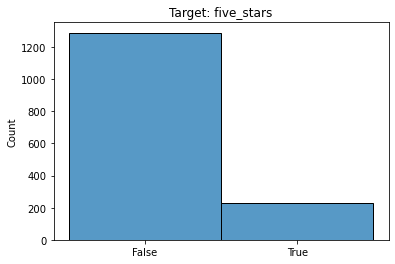

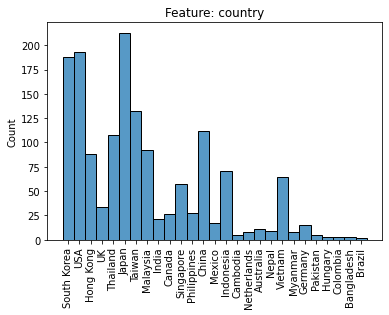

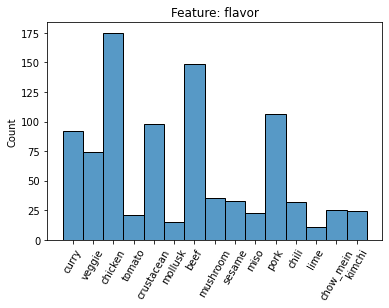

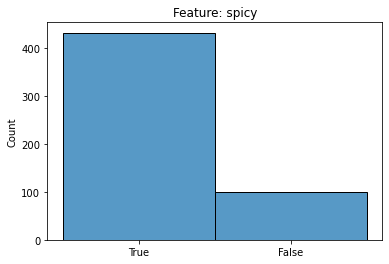

In [68]:
# initial univariate histograms
sns.histplot(train.five_stars) # five_stars
plt.title('Target: five_stars')
plt.xlabel('')
plt.show()

sns.histplot(train.country) # country
plt.title('Feature: country')
plt.xticks(rotation=90)
plt.xlabel('')
plt.show()

sns.histplot(flavor_col) # flavor
plt.title('Feature: flavor')
plt.xticks(rotation=60)
plt.xlabel('')
plt.show()

sns.histplot(spicy_col) # spicy
plt.title('Feature: spicy')
plt.xlabel('')
plt.show()

# Our Chosen Features - Preparing to Look in Terms of Five-Star Reviews
We need to split out the country and flavor columns to make visual comparison easier. To do this, we will eliminate values that do not meet statistical minimums and create features for the values that meet requirements.

## Country and 5-Star Reviews
We will look at three metrics for each country:
1. Total number of reviews
2. Total number of five-star reviews
3. The proportion of five-star reviews

To break down the 'country' feature into valuable one-hot-encoded features, **we will only keep countries that have:**
1. At least 30 reviews
2. At least 5 five-star reviews

Countries that meet these requirements will be placed in a relative **low-, medium- or high-proportion bracket** for the proportion of 5-star reviews against total reviews for that country. These three brackets should prove valuable for a predictive model.

### Implementation

In [69]:
# init empty list for results
results_list = []
# iterate each country and check results
for cntry in train.country.unique().tolist():
    # get total count of country's reviews
    total_count = (train.country == cntry).sum()
    # get count of 5-star reviews for country
    count_5stars = (train[train.five_stars == 'True'].country == cntry).sum()
    # check if at least 5 5-star reviews
    enough = count_5stars >= 5
    # get proportion between 5-star reviews and total count
    proportion_5stars = count_5stars / total_count
    # add results to list
    results_list.append(f'{cntry} ({enough}): {total_count} reviews, {int(proportion_5stars * 100)}% 5-star')
    # print(cntry, 'has enough:', enough)

### Results
**Countries with enough 5-star reviews to continue (at least 5):**
> - **Japan:** 213 total reviews, 19% 5-star
> - **USA:** 193 total reviews, 8% 5-star
> - **South Korea:** 188 total reviews, 16% 5-star
> - **Taiwan:** 132 total reviews, 21% 5-star
> - **China:** 112 total reviews, 4% 5-star
> - **Thailand:** 108 total reviews, 8% 5-star
> - **Malaysia:** 92 total reviews, 34% 5-star
> - **Hong Kong:** 88 total reviews, 20% 5-star
> - **Indonesia:** 71 total reviews, 16% 5-star
> - **Singapore:** 57 total reviews, 28% 5-star

**Countries without enough 5-star reviews:**
> UK, India, Canada, Philippines, Mexico, Cambodia, Netherlands, Australia, Nepal, Vietnam, Myanmar, Germany, Pakistan, Hungary, Colombia, Bangladesh, Brazil 

Based on the results list, I've ordered the results below in terms of review count. I've also split the group into low-, medium-, and high-percentage countries.

In [70]:
# make list of final countries
final_countries = ['Japan', 'USA', 'South Korea', 'Taiwan', 'China', 'Thailand', 
                   'Malaysia', 'Hong Kong', 'Indonesia', 'Singapore']

# make three brackets based on 5-star proportion
high_percent_5star = ['Malaysia', 'Singapore', 'Taiwan']
mid_percent_5star = ['Hong Kong', 'Japan', 'South Korea', 'Indonesia']
low_percent_5star = ['China', 'Thailand', 'USA']

Now, we will create the features for these three brackets.

In [71]:
# high bracket
train['many_5stars_country'] = train.country.str.contains('|'.join(high_percent_5star))
# medium bracket
train['moderate_5stars_country'] = train.country.str.contains('|'.join(mid_percent_5star))
# low bracket
train['few_5stars_country'] = train.country.str.contains('|'.join(low_percent_5star))
# unknown bracket
train['unknown_5stars_country'] = train.country.str.contains('|'.join(final_countries)) == False

At this point, we'll drop the country column- we've analyzed it and created the necessary features from it.

In [72]:
# drop redundant country column
train.drop(columns='country', inplace=True)

## Flavor
We will apply similar requirements to Flavor as we did for Country.

We will look at three metrics for each flavor:
1. Total number of reviews
2. Total number of five-star reviews
3. The proportion of five-star reviews

To break down the 'flavor' feature into valuable one-hot-encoded features, **we will only keep flavors that have:**
1. At least 30 reviews
2. At least 5 five-star reviews

Flavors that meet these requirements will be placed in a relative **low-, medium- or high-proportion bracket** for the proportion of 5-star reviews against total reviews for that flavor. These three brackets should prove valuable for a predictive model.

### Implementation

In [73]:
non_null_flavor = train[train.flavor.isna() == False]
# init empty list for results
results_list = []
# iterate each flavor and check results
for flvr in non_null_flavor.flavor.unique().tolist():
    # get total count of flavor's reviews
    total_count = (non_null_flavor.flavor == flvr).sum()
    # get count of 5-star reviews for flavor
    count_5stars = (non_null_flavor[non_null_flavor.five_stars == 'True'].flavor == flvr).sum()
    # check if at least 5 5-star reviews
    enough = count_5stars >= 5
    # get proportion between 5-star reviews and total count
    proportion_5stars = count_5stars / total_count
    # add results to list
    results_list.append(f'{flvr} ({enough}): {total_count} reviews, {int(proportion_5stars * 100)}% 5-star')

### Results
**Flavors with enough 5-star reviews to continue (at least 5):**
> - **chicken:** 175 reviews, 9% 5-star
> - **beef:** 149 reviews, 4% 5-star
> - **pork:** 106 reviews, 17% 5-star
> - **crustacean:** 98 reviews, 16% 5-star
> - **curry:** 92 reviews, 28% 5-star
> - **sesame:** 33 reviews, 24% 5-star

**Flavors without enough 5-star reviews:**
> UK, India, Canada, Philippines, Mexico, Cambodia, Netherlands, Australia, Nepal, Vietnam, Myanmar, Germany, Pakistan, Hungary, Colombia, Bangladesh, Brazil 

Based on the results list, I've ordered the results below in terms of review count. I've also split the group into low-, medium-, and high-percentage flavors.

In [74]:
# make list of final flavors
final_flavors = ['curry', 'chicken', 'crustacean', 'beef', 'sesame', 'pork']

# make three brackets based on 5-star proportion
high_percent_5star = ['curry', 'sesame']
mid_percent_5star = ['pork', 'crustacean']
low_percent_5star = ['chicken', 'beef']

Now, we will create the features for these three brackets.

In [75]:
# high bracket
train['many_5stars_flavor'] = train.flavor.str.contains('|'.join(high_percent_5star))
# medium bracket
train['moderate_5stars_flavor'] = train.flavor.str.contains('|'.join(mid_percent_5star))
# low bracket
train['few_5stars_flavor'] = train.flavor.str.contains('|'.join(low_percent_5star))
# unknown bracket
train['unknown_5stars_flavor'] = train.flavor.str.contains('|'.join(final_flavors)) == False

In [76]:
train['unknown_5stars_flavor']

2566    False
332     False
1363    False
1888     True
1628    False
        ...  
308      True
379     False
294      True
1083     True
2127    False
Name: unknown_5stars_flavor, Length: 1515, dtype: bool

At this point, we'll drop the flavor column- we've analyzed it and created the necessary features from it.

In [77]:
# drop redundant flavor column
train.drop(columns='flavor', inplace=True)

# Final Features in Terms of Five-Star Reviews
Now, we will visualize our features in terms of five-star reviews.

-------------------- spicy --------------------
True     433
False     99
Name: spicy, dtype: int64


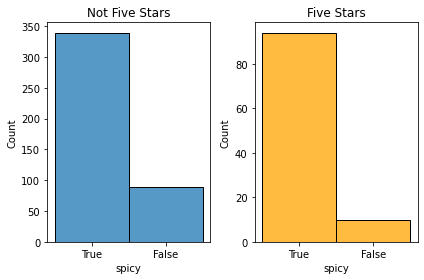

Not 5-Star t/f ratio: 79%
Is 5-Star t/f ratio: 90%
Percent Difference of Is 5-Star / Not 5-Star: 114%
-------------------- many_5stars_country --------------------
False    1234
True      281
Name: many_5stars_country, dtype: int64


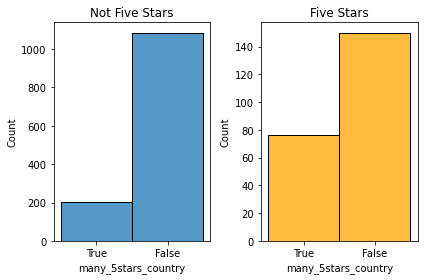

Not 5-Star t/f ratio: 15%
Is 5-Star t/f ratio: 33%
Percent Difference of Is 5-Star / Not 5-Star: 211%
-------------------- moderate_5stars_country --------------------
False    955
True     560
Name: moderate_5stars_country, dtype: int64


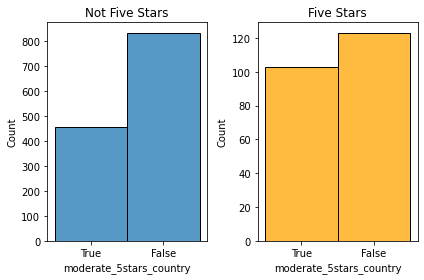

Not 5-Star t/f ratio: 35%
Is 5-Star t/f ratio: 45%
Percent Difference of Is 5-Star / Not 5-Star: 128%
-------------------- few_5stars_country --------------------
False    1102
True      413
Name: few_5stars_country, dtype: int64


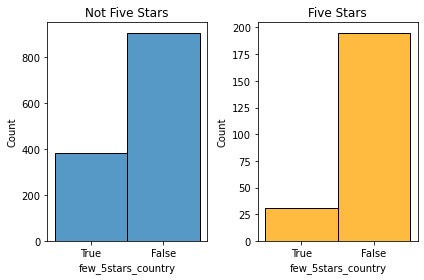

Not 5-Star t/f ratio: 29%
Is 5-Star t/f ratio: 13%
Percent Difference of Is 5-Star / Not 5-Star: 46%
-------------------- unknown_5stars_country --------------------
False    1254
True      261
Name: unknown_5stars_country, dtype: int64


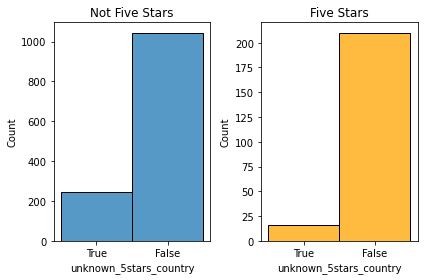

Not 5-Star t/f ratio: 19%
Is 5-Star t/f ratio: 7%
Percent Difference of Is 5-Star / Not 5-Star: 37%
-------------------- many_5stars_flavor --------------------
False    788
True     125
Name: many_5stars_flavor, dtype: int64


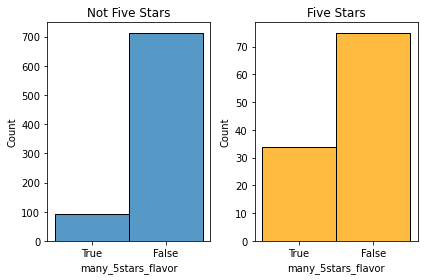

Not 5-Star t/f ratio: 11%
Is 5-Star t/f ratio: 31%
Percent Difference of Is 5-Star / Not 5-Star: 275%
-------------------- moderate_5stars_flavor --------------------
False    709
True     204
Name: moderate_5stars_flavor, dtype: int64


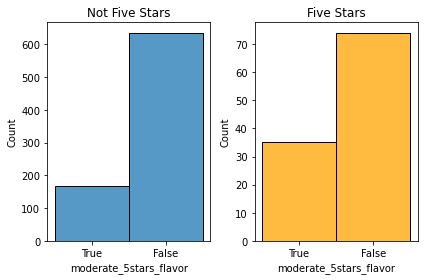

Not 5-Star t/f ratio: 21%
Is 5-Star t/f ratio: 32%
Percent Difference of Is 5-Star / Not 5-Star: 152%
-------------------- few_5stars_flavor --------------------
False    589
True     324
Name: few_5stars_flavor, dtype: int64


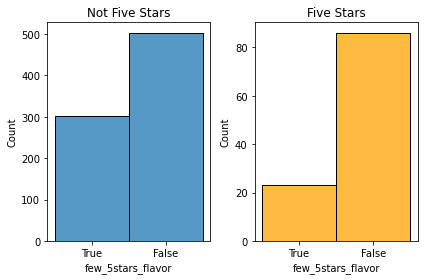

Not 5-Star t/f ratio: 37%
Is 5-Star t/f ratio: 21%
Percent Difference of Is 5-Star / Not 5-Star: 56%
-------------------- unknown_5stars_flavor --------------------
False    1255
True      260
Name: unknown_5stars_flavor, dtype: int64


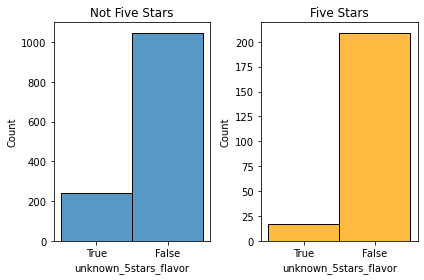

Not 5-Star t/f ratio: 18%
Is 5-Star t/f ratio: 7%
Percent Difference of Is 5-Star / Not 5-Star: 39%


In [78]:
# iterate through each non-target feature
for col in train.columns[1:]:
    # create samples based on 5-star and not 5-star reviews
    col_not_5star = train[train.five_stars == 'False'][col].dropna().astype('str')
    col_is_5star = train[train.five_stars == 'True'][col].dropna().astype('str')
    # viz header
    print('-'*20, col, '-'*20)
    print(train[col].value_counts())
    # visualization
    plt.subplot(121) # Observations without five_stars (left charts)
    plt.title('Not Five Stars')
    sns.histplot(col_not_5star.sort_values(ascending=False))
    plt.subplot(122) # Observations with five_stars (right charts)
    plt.title('Five Stars')
    sns.histplot(col_is_5star.sort_values(ascending=False), color='#ffa500')
    plt.tight_layout()
    plt.show()
    not_5star_ratio = (col_not_5star == "True").sum() / col_not_5star.shape[0]
    is_5star_ratio = (col_is_5star == "True").sum() / col_is_5star.shape[0]
    percent_difference = is_5star_ratio / not_5star_ratio
    print(f'Not 5-Star t/f ratio: {int(not_5star_ratio * 100)}%')
    print(f'Is 5-Star t/f ratio: {int(is_5star_ratio * 100)}%')
    print(f'Percent Difference of Is 5-Star / Not 5-Star: {int(percent_difference * 100)}%')

## Features Against the Target - Results
These results come from the above visualizations. Simply put, it compares the ratio in the blue charts against the ratio in the orange charts. **Larger differences in ratio are great as features for a predictive model.**
> - **spicy: 14% increase;** 79% ratio in Not 5-Star -> 90% ratio in Is 5-Star
> - **many_5stars_country: 111% increase;** 15% ratio in Not 5-Star -> 33% ratio in Is 5-Star
> - **moderate_5stars_country: 28% increase;** 35% ratio in Not 5-Star -> 45% ratio in Is 5-Star
> - **few_5stars_country: 54% decrease;** 29% ratio in Not 5-Star -> 13% ratio in Is 5-Star
> - **unknown_5stars_country: 63% decrease;** 19% ratio in Not 5-Star -> 7% ratio in Is 5-Star
> - **many_5stars_flavor: 175% increase;** 11% ratio in Not 5-Star -> 31% ratio in Is 5-Star
> - **moderate_5stars_flavor: 52% increase;** 21% ratio in Not 5-Star -> 32% ratio in Is 5-Star
> - **few_5stars_flavor: 44% decrease;** 37% ratio in Not 5-Star -> 21% ratio in Is 5-Star
> - **unknown_5stars_flavor: 61% decrease;** 18% ratio in Not 5-Star -> 7% ratio in Is 5-Star

# Exploration Conclusion
In summary, this is the work done in Explore:
- Used statistical analysis against our existing features for Brand, Country, and Packaging
    * Eliminated Ramen Brand and Packaging because they are independent from the target
    * Kept Ramen Country of Origin because it has a dependent relationship with the target
- Used feature engineering to split out the Ramen Product Name column.
    * Split product names into keywords
    * Conducted domain research and translation to determine which categories a keyword belongs to
    * Grouped relevant keywords into features
    * Ran statistical tests to determine if the new features have a relationship with the target
    * Eliminated features that did not have a relationship with the target
    * Eliminated low-count or irrelevant keywords from important features
    * Split keywords back out from feature into low-, medium-, and high-proportion groups in terms of 5-Stars
    * Created new features for the new brackets, including an 'unknown' bracket
    * Checked final features against the target in terms of proportionality

**All of these features are technically valid for the model. We will recreate these features in wrangle.py for each data split.**

## Test wrangle.py Function for Preparing for Modeling

In [79]:
# run the modeling prep script
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.prep_model()

print('X_validate shape:', X_validate.shape)

Train size: (1515, 11) Validate size: (506, 11) Test size: (506, 11)
X_validate shape: (506, 10)


In [80]:
for col in X_train.columns:
    print(X_train[col].value_counts())
    print('-'*80)

False    1069
True      446
Name: is_spicy, dtype: int64
--------------------------------------------------------------------------------
False    1416
True       99
Name: not_spicy, dtype: int64
--------------------------------------------------------------------------------
False    1234
True      281
Name: many_5stars_country, dtype: int64
--------------------------------------------------------------------------------
False    955
True     560
Name: moderate_5stars_country, dtype: int64
--------------------------------------------------------------------------------
False    1102
True      413
Name: few_5stars_country, dtype: int64
--------------------------------------------------------------------------------
False    1254
True      261
Name: unknown_5stars_country, dtype: int64
--------------------------------------------------------------------------------
False    1390
True      125
Name: many_5stars_flavor, dtype: int64
--------------------------------------------------------